In [ ]:
pip install datasets

In [ ]:
import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')
from bs4 import BeautifulSoup

In [ ]:
data=datasets.load_dataset('quora',split="train")

Using custom data configuration default
Reusing dataset quora (/root/.cache/huggingface/datasets/quora/default/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04)


In [ ]:
qframe=pd.DataFrame(data['questions'])
dupframe=np.array(data['is_duplicate'],dtype='i')


In [ ]:
np_array=[]
for i in range(len(qframe)):
    np_array.append([qframe['id'][i][0],qframe['id'][i][1],qframe['text'][i][0],qframe['text'][i][1],dupframe[i]])

In [ ]:
train_data=pd.DataFrame(np_array,columns=['qid1','qid2','question1','question2','is_duplicate'])

In [ ]:
train_data.isnull().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [ ]:
train_data.duplicated().sum()

0

In [ ]:
# Distribution of duplicated and non duplicated questions
print(train_data['is_duplicate'].value_counts())

0    255027
1    149263
Name: is_duplicate, dtype: int64


In [ ]:
qids=pd.Series(train_data['qid1'].to_list()+train_data['qid2'].to_list())
print('Unique Questions=',np.unique(qids).shape[0])
x=qids.value_counts()>1
print('Repeated Questions=',x[x].shape[0])

Unique Questions= 537933
Repeated Questions= 111780


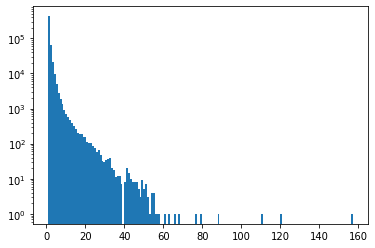

In [ ]:
#Repeated Questions Histogram
plt.hist(qids.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

In [ ]:
train_data=train_data.sample(30000,random_state=2)

In [ ]:
train_data['question1'] = train_data['question1'].apply(lambda x: str(x))
train_data['question2'] = train_data['question2'].apply(lambda x: str(x))

# Training and Testing without any feature engineering

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
#merge texts
questions=list(train_data['question1'])+list(train_data['question2'])
tfidf=TfidfVectorizer()
tfidf.fit_transform(questions)
# q1_arr,q2_arr=np.vsplit(tfidf.fit_transform(questions).toarray(),2)
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [ ]:
from tqdm import tqdm
import spacy

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 =[]
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar

for qu1 in tqdm(list(train_data['question1'])):
  doc1 = nlp(qu1)
  #384 is the number of dimensions of vectors
  mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)]) 
  for word1 in doc1:
    #word2vec
    vec1 = word1.vector
    #fetch df score
    try:
      idf = word2tfidf[str(word1)]
    except:
      idf = 0
    
    # compute final vec
    mean_vec1 += vec1 * idf
  mean_vec1 = mean_vec1.mean(axis= 0)
  vecs1.append(mean_vec1)

train_data['q1_feats_m'] = list(vecs1)
 

100%|██████████| 30000/30000 [05:20<00:00, 93.71it/s] 


In [ ]:
tempq_df1 = train_data.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
tempq_df1 = pd.DataFrame(tempq_df1.q1_feats_m.values.tolist(), index= tempq_df1.index)

In [ ]:
nlp = spacy.load('en_core_web_sm')

vecs2 = []
for qu2 in tqdm(list(train_data['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
train_data['q2_feats_m'] = list(vecs2)


100%|██████████| 30000/30000 [05:23<00:00, 92.66it/s] 


In [ ]:
tempq_df2 = train_data.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
tempq_df2 = pd.DataFrame(tempq_df2.q2_feats_m.values.tolist(), index= tempq_df2.index)

In [ ]:
temp_df=pd.concat([tempq_df1,tempq_df2],axis=1)
temp_df.shape

(30000, 6000)

In [ ]:
temp_df['is_duplicate']=train_data['is_duplicate']

In [ ]:
temp_df

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
118081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
206408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
156217,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
101550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103691,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
72732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=42)

# Training using RandomForest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf=RandomForestClassifier()
rf.fit(X_train,Y_train)


RandomForestClassifier()

### Accuracy

In [ ]:
y_pred=rf.predict(X_test)
print(accuracy_score(y_pred,Y_test))

0.7385


# Training using XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb=XGBClassifier()
xgb.fit(X_train,Y_train)

XGBClassifier()

### Accuracy

In [ ]:
y_pred=xgb.predict(X_test)
print(accuracy_score(y_pred,Y_test))


0.6871666666666667


## Creating new features for better interpretation

In [ ]:
train_data['q1_len']=train_data['question1'].str.len()
train_data['q2_len']=train_data['question2'].str.len()

In [ ]:
train_data.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
105979,25737,174654,What are the best drop shipping niche?,What are the top drop shipping companies?,0,38,41
101101,167548,167549,Why would Trump not make a good president?,What are some actual reasons why people think ...,0,42,121
138801,220950,42588,How similar are Orthodox Jews to the Amish?,Is belief in God vital to be an orthodox Jew?,0,43,45
322135,24963,253662,Who is likely to become the next President of ...,Who can become the next President of India and...,1,52,51
333168,253460,192611,Which is a suitable inpatient drug and alcohol...,Which is a suitable inpatient drug and alcohol...,0,80,79


In [ ]:
train_data['q1_num_words']=train_data['question1'].apply(lambda row:len(row.split(" ")))
train_data['q2_num_words']=train_data['question2'].apply(lambda row:len(row.split(" ")))

In [ ]:
train_data.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
105979,25737,174654,What are the best drop shipping niche?,What are the top drop shipping companies?,0,38,41,7,7
101101,167548,167549,Why would Trump not make a good president?,What are some actual reasons why people think ...,0,42,121,8,19
138801,220950,42588,How similar are Orthodox Jews to the Amish?,Is belief in God vital to be an orthodox Jew?,0,43,45,8,10
322135,24963,253662,Who is likely to become the next President of ...,Who can become the next President of India and...,1,52,51,10,10
333168,253460,192611,Which is a suitable inpatient drug and alcohol...,Which is a suitable inpatient drug and alcohol...,0,80,79,14,14


In [ ]:
def common_words(row):
  w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
  w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
  return len(w1 & w2)

In [ ]:
train_data['words_common']=train_data.apply(common_words,axis=1)

In [ ]:
train_data

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,words_common
105979,25737,174654,What are the best drop shipping niche?,What are the top drop shipping companies?,0,38,41,7,7,5
101101,167548,167549,Why would Trump not make a good president?,What are some actual reasons why people think ...,0,42,121,8,19,5
138801,220950,42588,How similar are Orthodox Jews to the Amish?,Is belief in God vital to be an orthodox Jew?,0,43,45,8,10,2
322135,24963,253662,Who is likely to become the next President of ...,Who can become the next President of India and...,1,52,51,10,10,6
333168,253460,192611,Which is a suitable inpatient drug and alcohol...,Which is a suitable inpatient drug and alcohol...,0,80,79,14,14,13
...,...,...,...,...,...,...,...,...,...,...
89183,149880,149881,When and how did the Assamese festival of Bihu...,What do the Assamese eat?,0,57,25,10,5,2
79950,136025,136026,Is Donald Trump being investigated by the FBI?,"If the FBI is investigating Donald Trump, shou...",0,46,129,8,21,3
336793,464185,464186,Can I take my arrear exam now?,Can I give my arrear exam now?,1,30,30,7,7,6
93178,155851,155852,Can somebody help me with this math problem?,Can anyone help me in this maths problem?,0,45,41,9,8,5


In [ ]:
def total_words(row):
  w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
  w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
  return (len(w1)+len(w2))

In [ ]:
train_data['words_total']=train_data.apply(total_words,axis=1)

In [ ]:
train_data.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,words_common,words_total
105979,25737,174654,What are the best drop shipping niche?,What are the top drop shipping companies?,0,38,41,7,7,5,14
101101,167548,167549,Why would Trump not make a good president?,What are some actual reasons why people think ...,0,42,121,8,19,5,27
138801,220950,42588,How similar are Orthodox Jews to the Amish?,Is belief in God vital to be an orthodox Jew?,0,43,45,8,10,2,18
322135,24963,253662,Who is likely to become the next President of ...,Who can become the next President of India and...,1,52,51,10,10,6,20
333168,253460,192611,Which is a suitable inpatient drug and alcohol...,Which is a suitable inpatient drug and alcohol...,0,80,79,14,14,13,28


In [ ]:
train_data['word_share']=round(train_data['words_common']/train_data['words_total'],2)

In [ ]:
train_data.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,words_common,words_total,word_share
105979,25737,174654,What are the best drop shipping niche?,What are the top drop shipping companies?,0,38,41,7,7,5,14,0.36
101101,167548,167549,Why would Trump not make a good president?,What are some actual reasons why people think ...,0,42,121,8,19,5,27,0.19
138801,220950,42588,How similar are Orthodox Jews to the Amish?,Is belief in God vital to be an orthodox Jew?,0,43,45,8,10,2,18,0.11
322135,24963,253662,Who is likely to become the next President of ...,Who can become the next President of India and...,1,52,51,10,10,6,20,0.30
333168,253460,192611,Which is a suitable inpatient drug and alcohol...,Which is a suitable inpatient drug and alcohol...,0,80,79,14,14,13,28,0.46


minimum characters 1
maximum characters 413
average num of characters 59


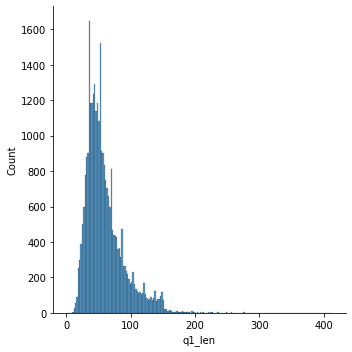

In [ ]:
# Analysis of features
sns.displot(train_data['q1_len'])
print('minimum characters',train_data['q1_len'].min())
print('maximum characters',train_data['q1_len'].max())
print('average num of characters',int(train_data['q1_len'].mean()))

minimum characters 4
maximum characters 1151
average num of characters 60


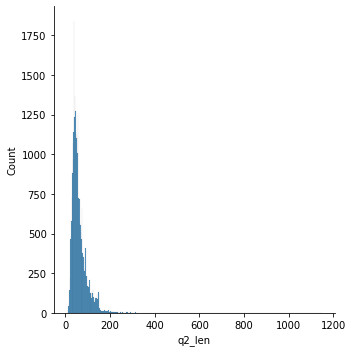

In [ ]:
sns.displot(train_data['q2_len'])
print('minimum characters',train_data['q2_len'].min())
print('maximum characters',train_data['q2_len'].max())
print('average num of characters',int(train_data['q2_len'].mean()))

minimum words 1
maximum words 79
average num of words 10


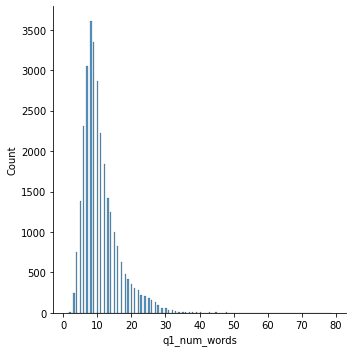

In [ ]:
sns.displot(train_data['q1_num_words'])
print('minimum words',train_data['q1_num_words'].min())
print('maximum words',train_data['q1_num_words'].max())
print('average num of words',int(train_data['q1_num_words'].mean()))

minimum words 1
maximum words 237
average num of words 11


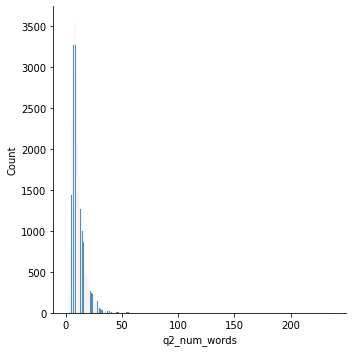

In [ ]:
sns.displot(train_data['q2_num_words'])
print('minimum words',train_data['q2_num_words'].min())
print('maximum words',train_data['q2_num_words'].max())
print('average num of words',int(train_data['q2_num_words'].mean()))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


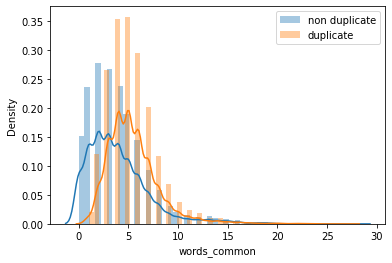

In [ ]:
# common words
sns.distplot(train_data[train_data['is_duplicate'] == 0]['words_common'],label='non duplicate')
sns.distplot(train_data[train_data['is_duplicate'] == 1]['words_common'],label='duplicate')
plt.legend()
plt.show()


### Above plot shows that if common words is less than 4 then it is non duplicate

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


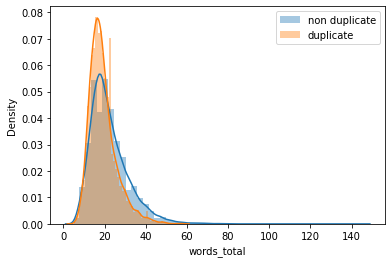

In [ ]:
# total words
sns.distplot(train_data[train_data['is_duplicate'] == 0]['words_total'],label='non duplicate')
sns.distplot(train_data[train_data['is_duplicate'] == 1]['words_total'],label='duplicate')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


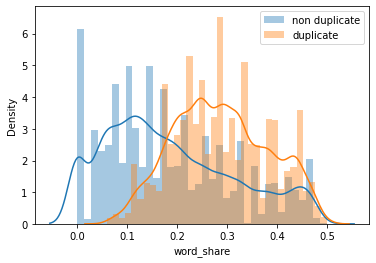

In [ ]:
# word share
sns.distplot(train_data[train_data['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(train_data[train_data['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

### Above plot shows that if word share is less than 0.2 then questions are non duplicate

In [ ]:
ques_df = train_data[['question1','question2']]
ques_df.head()

,question1,question2
105979,What are the best drop shipping niche?,What are the top drop shipping companies?
101101,Why would Trump not make a good president?,What are some actual reasons why people think ...
138801,How similar are Orthodox Jews to the Amish?,Is belief in God vital to be an orthodox Jew?
322135,Who is likely to become the next President of ...,Who can become the next President of India and...
333168,Which is a suitable inpatient drug and alcohol...,Which is a suitable inpatient drug and alcohol...


In [ ]:
final_df = train_data.drop(columns=['qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 8)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,words_common,words_total,word_share
105979,0,38,41,7,7,5,14,0.36
101101,0,42,121,8,19,5,27,0.19
138801,0,43,45,8,10,2,18,0.11
322135,1,52,51,10,10,6,20,0.30
333168,0,80,79,14,14,13,28,0.46


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [ ]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [ ]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6008)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,words_common,words_total,word_share,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
105979,0,38,41,7,7,5,14,0.36,0,0,...,0,0,0,0,0,0,0,0,0,0
101101,0,42,121,8,19,5,27,0.19,0,0,...,0,0,0,0,0,0,0,0,0,0
138801,0,43,45,8,10,2,18,0.11,0,0,...,0,0,0,0,0,0,0,0,0,0
322135,1,52,51,10,10,6,20,0.30,0,0,...,0,0,0,0,0,0,0,0,0,0
333168,0,80,79,14,14,13,28,0.46,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7748333333333334

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.7313333333333333

# Increasing Accuracy Using some Advance features

###Advanced Features
1. Token Features
- cwc_min: This is the ratio of the number of common words to the length of the smaller question
- cwc_max: This is the ratio of the number of common words to the length of the larger question
- csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions
- csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions
- ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions
- ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions
- last_word_eq: 1 if the last word in the two questions is same, 0 otherwise
- first_word_eq: 1 if the first word in the two questions is same, 0 otherwise
2. Length Based Features
- mean_len: Mean of the length of the two questions (number of words)
- abs_len_diff: Absolute difference between the length of the two questions (number of words)
- longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question
3. Fuzzy Features
- fuzz_ratio: fuzz_ratio score from fuzzywuzzy
- fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
- token_sort_ratio: token_sort_ratio from fuzzywuzzy
- token_set_ratio: token_set_ratio from fuzzywuzzy

In [ ]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q
    

In [ ]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [ ]:
train_data['question1'] = train_data['question1'].apply(preprocess)
train_data['question2'] = train_data['question2'].apply(preprocess)

In [ ]:
train_data.head()

,qid1,qid2,question1,question2,is_duplicate
398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0
327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0
367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


In [ ]:
train_data['q1_len'] = train_data['question1'].str.len() 
train_data['q2_len'] = train_data['question2'].str.len()

In [ ]:
train_data['q1_num_words'] = train_data['question1'].apply(lambda row: len(row.split(" ")))
train_data['q2_num_words'] = train_data['question2'].apply(lambda row: len(row.split(" ")))
train_data.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13
115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16
327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21
367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32
151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9


In [ ]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [ ]:
train_data['word_common'] = train_data.apply(common_words, axis=1)
train_data.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12
115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8
327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4
367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1
151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3


In [ ]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [ ]:

train_data['word_total'] = train_data.apply(total_words, axis=1)
train_data.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26
115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24
327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38
367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34
151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13


In [ ]:
train_data['word_share'] = round(train_data['word_common']/train_data['word_total'],2)
train_data.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,0.46
115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,0.33
327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,0.11
367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,0.03
151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


In [ ]:
# Advanced Features
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
token_features = train_data.apply(fetch_token_features, axis=1)

train_data["cwc_min"]       = list(map(lambda x: x[0], token_features))
train_data["cwc_max"]       = list(map(lambda x: x[1], token_features))
train_data["csc_min"]       = list(map(lambda x: x[2], token_features))
train_data["csc_max"]       = list(map(lambda x: x[3], token_features))
train_data["ctc_min"]       = list(map(lambda x: x[4], token_features))
train_data["ctc_max"]       = list(map(lambda x: x[5], token_features))
train_data["last_word_eq"]  = list(map(lambda x: x[6], token_features))
train_data["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [ ]:
train_data.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,0.46,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0
115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,0.33,0.666644,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0
327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,0.11,0.000000,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0
367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0


In [ ]:
pip install distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [ ]:
length_features = train_data.apply(fetch_length_features, axis=1)

train_data['abs_len_diff'] = list(map(lambda x: x[0], length_features))
train_data['mean_len'] = list(map(lambda x: x[1], length_features))
train_data['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [ ]:
train_data.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,...,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0,0.0,13.0,0.855263
115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,...,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0,3.0,13.5,0.224490
327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,...,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0,6.0,23.0,0.047619
367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,17.0,21.5,0.050847
151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,...,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0,4.0,7.0,0.542857


In [ ]:
pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
fuzzy_features = train_data.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
train_data['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
train_data['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
train_data['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
train_data['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [ ]:
print(train_data.shape)
train_data.head()

(30000, 27)


,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,...,0.923070,1.0,1.0,0.0,13.0,0.855263,99,99,99,99
115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,...,0.466664,1.0,1.0,3.0,13.5,0.224490,69,67,65,74
327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,...,0.115384,0.0,0.0,6.0,23.0,0.047619,26,29,34,43
367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,...,0.000000,0.0,0.0,17.0,21.5,0.050847,29,41,23,30
151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,...,0.333330,1.0,0.0,4.0,7.0,0.542857,55,70,48,69


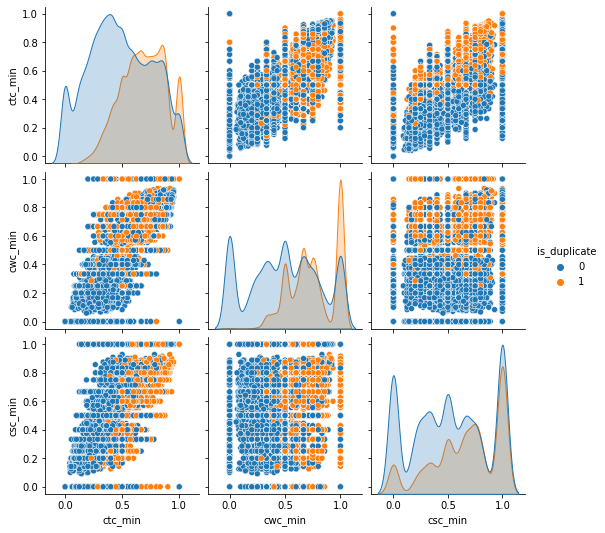

In [ ]:

sns.pairplot(train_data[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

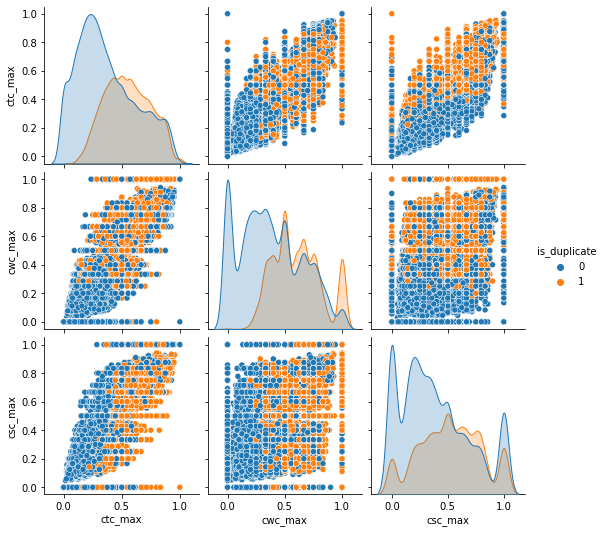

In [ ]:
sns.pairplot(train_data[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

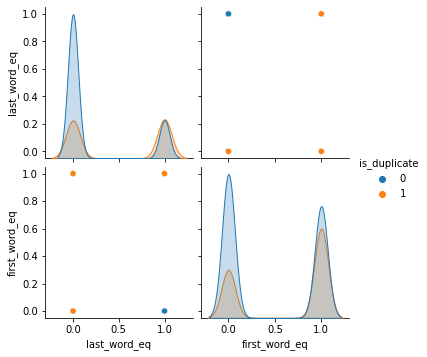

In [ ]:
sns.pairplot(train_data[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

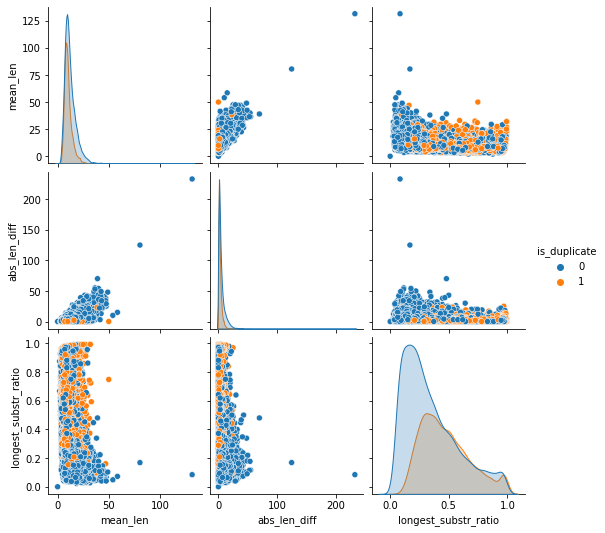

In [ ]:
sns.pairplot(train_data[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

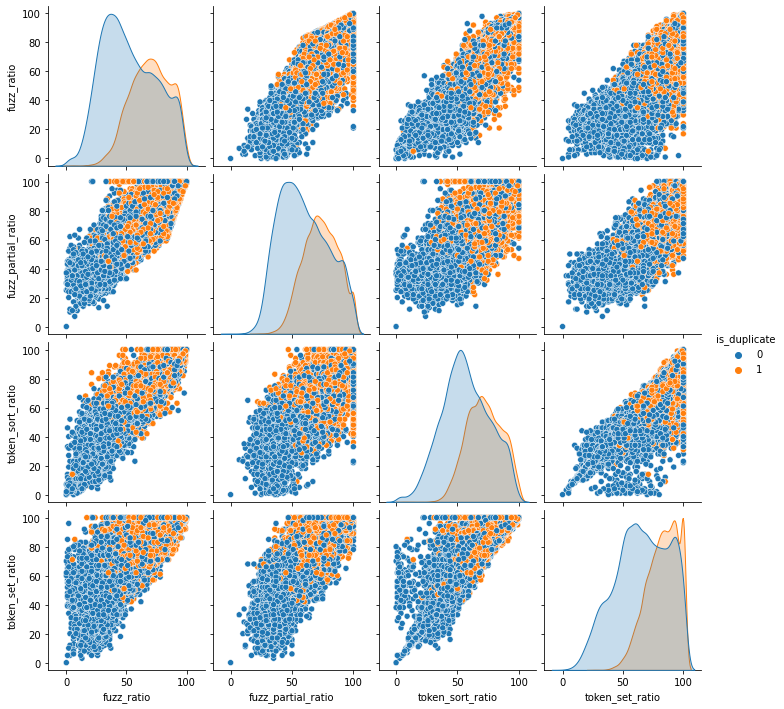

In [ ]:
sns.pairplot(train_data[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(train_data[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = train_data['is_duplicate'].values

In [ ]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.133s...
[t-SNE] Computed neighbors for 30000 samples in 10.569s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sa

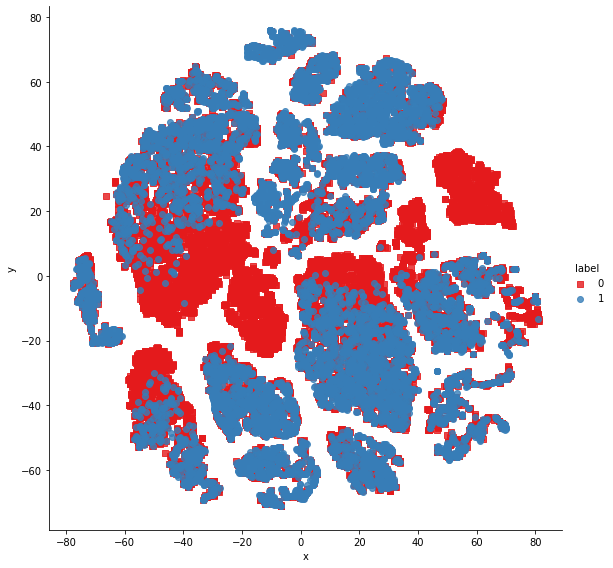

In [ ]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])

In [ ]:
ques_df = train_data[['question1','question2']]
ques_df.head()

NameError: ignored

In [ ]:
final_df = train_data.drop(columns=['qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = TfidfVectorizer()
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [ ]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

In [ ]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0,0,0,0,0,0,0,0,0,0
115086,0,48,56,13,16,8,24,0.33,0.666644,0.499988,...,0,0,0,0,0,0,0,0,0,0
327711,0,104,119,28,21,4,38,0.11,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
367788,0,58,145,14,32,1,34,0.03,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7855

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)


In [ ]:
accuracy_score(y_test,y_pred1)

0.7596666666666667

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# for random forest model
confusion_matrix(y_test,y_pred1)

array([[3198,  614],
       [ 828, 1360]])

# Using Deep Learning Model

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
!pip install transformers==2.11.0
import transformers

In [ ]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = [1,0]
#1 : Non Duplicate
#0 : Duplicate

In [ ]:
#create mask for train-test distribution
mask = np.random.rand(len(train_data)) < 0.7
train_df = train_data[mask]
not_train = train_data[~mask]

#create mask for val-test distribution
mask = np.random.rand(len(not_train)) < 0.5
test_df = not_train[mask]
val_df = not_train[~mask]
val_df.head(5)

,qid1,qid2,question1,question2,is_duplicate
6,13,14,should i buy tiago,what keeps childern active and far from phone ...,0
7,15,16,how can i be a good geologist,what should i do to be a great geologist,1
25,51,52,what are some tips on making it through the jo...,what are some tips on making it through the jo...,0
34,69,70,what is the best travel website in spain,what is the best travel website,0
38,77,78,how do we prepare for upsc,how do i prepare for civil service,1


In [ ]:
# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {val_df.shape[0]}")
print(f"Total test samples: {test_df.shape[0]}")

Total train samples : 283029
Total validation samples: 60561
Total test samples: 60700


In [ ]:
print("Train Target Distribution")
print(train_df.is_duplicate.value_counts())

print("Validation Target Distribution")
print(val_df.is_duplicate.value_counts())

Train Target Distribution
0    178720
1    104309
Name: is_duplicate, dtype: int64
Validation Target Distribution
0    37977
1    22584
Name: is_duplicate, dtype: int64


In [ ]:
y_train = tf.keras.utils.to_categorical(train_df.is_duplicate, num_classes=2)#One hot encodding representation
print(f"y_train.shape:{y_train.shape}")

y_val = tf.keras.utils.to_categorical(val_df.is_duplicate, num_classes=2)
print(f"y_val.shape:{y_val.shape}")

y_test = tf.keras.utils.to_categorical(test_df.is_duplicate, num_classes=2)
print(f"y_test.shape:{y_test.shape}")

y_train.shape:(283029, 2)
y_val.shape:(60561, 2)
y_test.shape:(60700, 2)


In [ ]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [ ]:
strategy = tf.distribute.MirroredStrategy()# Create the model under a distribution strategy scope.

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    sequence_output, pooled_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
    
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7ff2df179350>
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                       

In [ ]:
train_data = BertSemanticDataGenerator(
    train_df[["question1", "question2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
val_data = BertSemanticDataGenerator(
    val_df[["question1", "question2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
     use_multiprocessing=True,
    workers=-1,
)

Epoch 1/2
6919/8844 [======================>.......] - ETA: 12:32 - loss: 0.4105 - acc: 0.7993